# Exploring Audio Data, Extracting Features
Kartik Nanda, Mar 2020

This script loads the audio clip, computes the mel spectrogram of the clip (at multiple sample rates if specified), and saves the spectrogram 2D array for input to a CNN. Can also be used to explore and examine the audio clip(s) - various plots etc.

In [54]:
# install librosa if required. The following is one way, but better is: >conda install -c conda-forge librosa
# !pip install librosa

In [1]:
import glob
import os
from pathlib import Path
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Define Constants

In [2]:
# Define some important constants - this needs to be moved to a separate included file
n_fft = 2048            # used for STFT: # samples used to generate fft
sample_rate = [44100, 8192, 1024]  # sample rates of the audio clips
cdur = 4                # clip duration in seconds
n_mels = 128            # num of mel freq bands output
ref = 32768             # reference power for mel db calculation

## Define key Functions
Functions to load audio files, plot waveform and transforms, extract features for further processing

In [3]:
# Load the sound file - currently it also does the following:
# generates plots: time, log_power_spectrogram
# input: single audio file, 
#        label, 
#        sample-rate (when loading, resamples to this rate, default=keep original file rate),
#        n_fft (number of samples used per fft, preferably power of 2, default=2048),
#        hop_length (determines overlap: hop = 0 means 100% overlap, hop = n_fft mean no overlap; def = n_fft/2)
#        p: set to True to generate plots

def load_sound(sound_file, sound_label, sr=None, n_fft=2048, hop_length=None, p=True):
    
    # Load the audio file (specify sample_rate sr)
    if p: print('Original Sample Rate: ', librosa.get_samplerate(sound_file))
    X, _sr = librosa.load(sound_file, sr)
    if p: print('New sr:', _sr)
    if p: print('Number of audio samples: ', X.shape[0])
    
    # Generate plots - time domain waveform, log power-spectrogram
    if (p):
        fig = plt.figure(figsize=(25,12))
        plt.subplot(2, 1, 1)
        librosa.display.waveplot(np.array(X), sr=_sr)              # plot the waveform
        plt.title("Waveplot")
    
        # Generate and Plot the spectrogram (DB scale)
        if hop_length == None:
            hop_length = int(n_fft/2)
        X_stft_cmplx = librosa.stft(X, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, center=True)
        X_stft_amp_db = librosa.amplitude_to_db(np.abs(X_stft_cmplx), ref=np.max)
        print(X_stft_amp_db.shape)

        plt.subplot(2, 1, 2)
        librosa.display.specshow(X_stft_amp_db, sr=_sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='magma');
        # plt.colorbar();
        plt.title("Log Power Spectrogram")
        plt.suptitle(sound_label.title(),x=0.5, y=0.95, fontsize=18)
        plt.show()

        print('Number of FFT slices', X_stft_amp_db.shape[1])

    return X, _sr


In [4]:
# Extract features from audio files, optionally plot features
# Features are mel sprectrogram at 44100 Hz and 1024 Hz, concatenated
def extract_feature(X, sound_label, sr, n_fft=2048, hop_length=None, p=True, n_mels=128, ref=255, cdur=0):
    
    # Check if the audio clip is the correct duration - truncate or pad as required
    if p: print ("Audio samples: ",len(X), "sampled at", sr, "hz")
    if (len(X)/sr > cdur):
        if p: print('Warning: Length of Audio Track is greater that', cdur,'sec; truncating')
        X = X[0:cdur*sr+1]
    elif (len(X)/sr < cdur):
        if p: print('Warning: Length of Audio Track is less that', cdur,'sec; padding')
        # need to pad
    
    # determine the hop_length
    if hop_length == None:
        hop_length = int(n_fft/2)
    
    # Calc. the Spectrogram (magnitude/energy and power)
    stft = np.abs(librosa.stft(X, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, center=True))
    X_spectrogram = np.abs(stft)**2
    
    # Calc. the mel-spectrogram
    mel = librosa.feature.melspectrogram(y=None, sr=sr, S=X_spectrogram, n_fft=n_fft, hop_length=hop_length, 
                                         win_length=n_fft, center=True, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=ref)
    
    # plot, if desired
    if (p):
        num_p = 1
        fig = plt.figure(figsize=(25,6*num_p))
        plt.subplot(num_p, 1, 1)
        librosa.display.specshow(mel_db, sr=sr, hop_length=hop_length, y_axis='mel', x_axis='time', fmax=sr/2)
        plt.colorbar();
        plt.title('Mel Freq. Spectrogram')
        plt.show()
        
    return mel_db, np.max(mel)

## Path Setup
Finding the Audio files

In [5]:
# Define paths
# path_raw_audio contains the audio clips and associated meta data
# path_dataset - the audio clips are converted to images (mel spectrogram) and saved here
# path_features - the output of the CNN, for further processing
path_proj = Path.cwd().parent                                      # The project directory
path_raw_audio = path_proj/'datasets'/'data_uw_sounds'             # The audio files
path_dataset = path_proj/'datasets'/'dataset_uw_sounds'            # Dataset for CNN train and valid 
path_features = path_proj/'features'/'uw_sounds'                   # The output folder - where the features are saved

In [6]:
path_proj

WindowsPath('C:/Users/kar16/Desktop/KartikNanda_LLC/KBSI/Development/audio_anomaly_model')

In [7]:
# This is a list of all the directories which contain the audio clips
file_paths = list(path_raw_audio.glob('*'))

In [8]:
len(file_paths)

800

## Main Loop
Generates the aggregate mel power spectrogram (db) for input to a DNN

In [19]:
# this is to select a single file, to test system
file1 = file_paths[70]
Path.is_file(file1)
class_name = file1.stem.split('-')[3] #file1.parent.name
class_name

'27'

In [9]:
# Run on the entire set

# make note of the max power in a band. This is used to (offline) set the reference
mel_max = []

# for all audio clips in file_paths
for p in file_paths[1:13]:
    class_name = p.stem.split('-')[0]
    mel_db = []
    err = False
    
    # for all (3) sample rates, load sound, calc mel spectrogram
    for sr in sample_rate:
        X, sr = load_sound(p, class_name, sr=sr, p=False)
        mel_spec, mm = extract_feature(X, class_name, sr=sr, p=False, n_mels=n_mels, ref=ref, cdur=cdur)
        if len(mel_spec) == 1:
            print('Error: Length of Audio Track is not', cdur)
            err = True
            break
        mel_db.append(mel_spec)
        mel_max.append(mm)
    
    if err: break
        
    # assemble the final mel spectrogram image, write to file
    meldb_agg = np.concatenate(mel_db, axis=1)
#     if (int(p.stem.split('-')[0])<5):
#         fnm = path_dataset/'train'/p.stem
#     else:
#         fnm = path_dataset/'valid'/p.stem
    fnm = path_dataset/p.stem
    np.savetxt(fnm, meldb_agg)
    
    if False:
        print('Mel_db shape:', mel_db[0].shape, mel_db[1].shape, mel_db[2].shape)
        print('Image shape:', meldb_agg.shape)
        print('Max value of the Mel spectrograms, max and min of meldb_agg:', mel_max, np.max(meldb_agg), np.min(meldb_agg))
        
if (err == False): print('Max of the mel spectrograms:', np.max(mel_max))   

Max of the mel spectrograms: 24777.664


In [10]:
meldb_agg.shape

(128, 211)

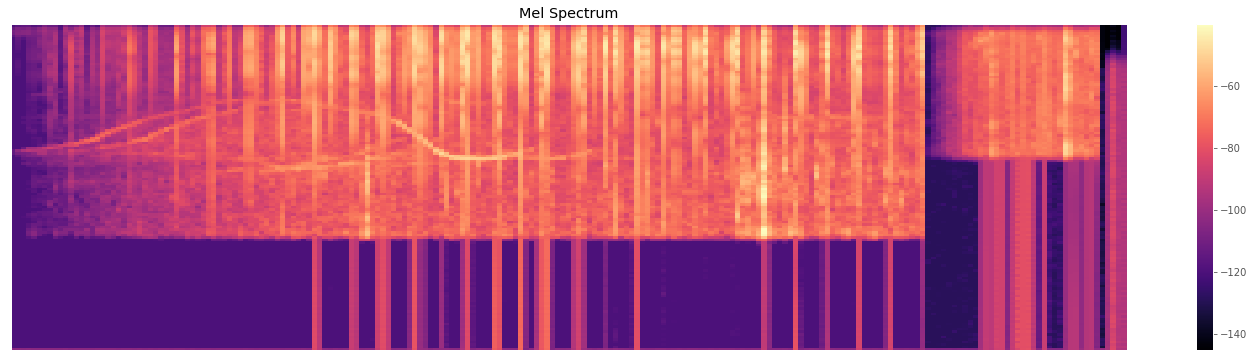

In [11]:
fig = plt.figure(figsize=(25,6))
librosa.display.specshow(meldb_agg, sr=sample_rate[0], hop_length=int(n_fft/2), fmax=sr/2)
plt.colorbar();
plt.title('Mel Spectrum')

plt.show()

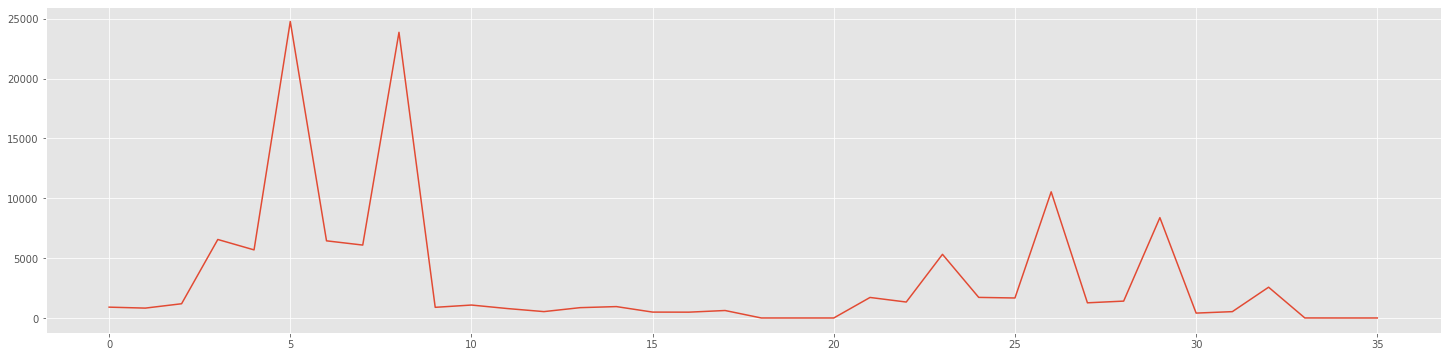

In [12]:
fig = plt.figure(figsize=(25,6))
plt.plot(mel_max)

In [192]:
fnm = path_features/'tmp'
np.savetxt(fnm, meldb_agg, delimiter=",")

In [207]:
fnm = path_features/'blue_whale-10'
bn = np.loadtxt(fnm)

In [208]:
bn.shape

(128, 211)

In [211]:
(bn == meldb_agg)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])